# Data visualization
In this notebook we have every function that plots something, let that be a histogram, a graph, anything. We are working with the following functions:
#### plot_graph(G)
    1. It takes a networkx graph object as an input and plots it
#### losses_epoch_plot
1) losses: list of the losses throughout the training session
2) save: boolean, decides if we should save the plot or not
3) save_name: The path where we save the plot if we want to save it
#### enhanced_histogram
1) data: the data we want to put on a histogram, typically the absolute value of the difference between the output and the test data
2) bins: the number of bins we want to divide the histogram into, default value is 30
3) save: boolean, decides if we should save the plot or not
4) save_name: The path where we save the plot if we want to save it

In [1]:
#Necessary imports
import sumolib
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

import torch
import torch_geometric
import torch_geometric.data as Data
import torch_geometric.utils as pyg_utils

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import json
import sys
import copy

In [4]:
def plot_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=False, node_size=1)
    plt.show()

In [5]:
def losses_epoch_plot(losses, save, save_name):
    fig = plt.figure()
    epochs = np.linspace(start=0, stop=np.size(losses), num=np.size(losses))
    plt.scatter(epochs,losses,c='red')
    plt.ylabel('Loss', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.grid(True,which='major',color='gray')
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction= 'in')
    plt.ylim([0,0.2])
    fig.set_size_inches(14,7.5)
    if save:
        plt.savefig(save_name)

In [6]:
def enhanced_histogram(data, bins=30, save=False, save_name='histogram.png'):
    fig = plt.figure()
    plt.hist(data, bins=bins, color='blue', edgecolor='black')
    plt.ylabel('Frequency', fontsize=20)
    plt.xlabel('Difference', fontsize=20)  # Changed to 'Difference' to reflect the data
    plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.7)
    plt.minorticks_on()
    plt.grid(True, which='minor', color='lightgray', linestyle=':', linewidth=0.5)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    fig.set_size_inches(14, 7.5)
    plt.title('Histogram of Differences', fontsize=22)  # Changed title to reflect the data

    if save:
        plt.savefig(save_name)
    plt.show()

In [1]:
def plot_graph_weight(G, model_output, hidden_edges, prepared_test_data_graph, name):
    matplotlib.rcParams.update({'font.size': 14})

    plt.figure(figsize=(16,9))

    pos = nx.get_node_attributes(G, 'pos')
    N = len(hidden_edges)
    #print(N)
    edges_to_hide_sort = hidden_edges
    edges_to_hide_sort.sort()
    difference = np.zeros(N)
    #print(edges_to_hide_sort)
    for i in range(N):
        if float(model_output[edges_to_hide_sort][i])<0:
            model_output[edges_to_hide_sort][i] = 0
        difference[i] = float(abs(model_output[edges_to_hide_sort][i] - prepared_test_data_graph.edge_attr[edges_to_hide_sort][i]))*(2*1800)/4
        #print(model_output[edges_to_hide_sort][i])

    maxdiff = max(difference)
    mindiff = 0
    maxdiff_int=int(maxdiff)
    #print(maxdiff)
    average = sum(difference) / len(difference)
    
    c = np.arange(10, maxdiff_int + 1)


    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])
     
    colors = [cmap(c/maxdiff) for c in difference]
    

    edge_colors = {edge: 'black' for edge in G.edges()}


    edges_to_color_edges = []
    edges=list(G.edges())
    edges_to_color_by_id=[]

    for i in edges_to_hide_sort:
        edges_to_color_edges.append(edges[i])
    for i in edges_to_color_edges:
        edges_to_color_by_id.append(G.edges[i]['edge_id'])
    #rint(edges_to_color_by_id)
    #print(len(edges_to_color_by_id))
    colorindexiter=0
    for edge in G.edges():
        edge_id = G.edges[edge]['edge_id']



        if edge_id in edges_to_color_by_id:

            edge_colors[edge] = colors[colorindexiter]
            colorindexiter+=1

    plt.axis([250, 3500, -500, 2500])
    nx.set_edge_attributes(G, edge_colors, 'color')

    edge_color_values = [G[u][v]['color'] for u, v in G.edges()]
    options = {
        

        "width": 3,
        "edge_cmap": plt.cm.Blues,
        "with_labels": False,
    }
    nx.draw(G, pos, **options, edge_color=edge_color_values, node_size=0) 
    
    norm = matplotlib.colors.Normalize(vmin=mindiff, vmax=maxdiff) 
  
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
    sm.set_array([]) 
    
    plt.colorbar(sm, ax=plt.gca(),ticks=np.linspace(mindiff, maxdiff,10)) 
    plt.title('Differences depicted on the graph with' + str(name) + "\n" + "Average:" + str(average))
    plt.show()
    return maxdiff

In [16]:
def GEH(M, C):
    geh = np.sqrt(2*np.power((float(M) - float(C)), 2) / (float(M) + float(C)))
    return geh

In [51]:
def plot_graph_weight_GEH(G,model_output,hidden_edges, prepared_test_data_graph, name):
    matplotlib.rcParams.update({'font.size': 14})

    plt.figure(figsize=(16,9))
    """ fig, ax = plt.subplots(dpi=100)
    mycax=ax.inset_axes[0.95, 0.1, 0.05, 0.8] """ 
    """ cax = plt.axes((0.85, 0.1, 0.075, 0.8)) """
    
    pos = nx.get_node_attributes(G, 'pos')

    N = len(hidden_edges)
    #print(N)
    edges_to_hide_sort = hidden_edges
    edges_to_hide_sort.sort()
    difference = np.zeros(N)
    #print(edges_to_hide_sort)

    for i in range(N):
        if model_output[edges_to_hide_sort][i]<0:
            model_output[edges_to_hide_sort][i] = 0
        M = float(model_output[edges_to_hide_sort][i]*(2*1800)/4)

        C = float(prepared_test_data_graph.edge_attr[edges_to_hide_sort][i]*(2*1800)/4)

        difference[i] = GEH(M, C)
 
    #print(difference)
    maxdiff = max(difference)
    mindiff = 0
    maxdiff_int=int(maxdiff)
    cleanedList= [x for x in difference if ~np.isnan(x)]
    average = sum(cleanedList) / len(cleanedList)
    c = np.arange(10, maxdiff_int + 1)


    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])
     
    colors = [cmap(c/maxdiff) for c in difference]
    

    edge_colors = {edge: 'black' for edge in G.edges()}


    edges_to_color_edges = []
    edges=list(G.edges())
    edges_to_color_by_id=[]

    for i in edges_to_hide_sort:
        edges_to_color_edges.append(edges[i])
    for i in edges_to_color_edges:
        edges_to_color_by_id.append(G.edges[i]['edge_id'])

    colorindexiter=0
    for edge in G.edges():
        edge_id = G.edges[edge]['edge_id']


        if edge_id in edges_to_color_by_id:

            edge_colors[edge] = colors[colorindexiter]
            colorindexiter+=1

    plt.axis([250, 3500, -500, 2500])
    nx.set_edge_attributes(G, edge_colors, 'color')

    edge_color_values = [G[u][v]['color'] for u, v in G.edges()]
    options = {
        

        "width": 3,
        "edge_cmap": plt.cm.Blues,
        "with_labels": False,
    }
    nx.draw(G, pos, **options, edge_color=edge_color_values, node_size=0) 
    
    norm = matplotlib.colors.Normalize(vmin=mindiff, vmax=maxdiff) 
  
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
    sm.set_array([]) 
    
    plt.colorbar(sm, ax=plt.gca(),ticks=np.linspace(mindiff, maxdiff,10)) 
    plt.title('GEH Differences depicted on the graph with' + str(name) + "\n" + "Average:" + str(average))
    plt.show()
    return maxdiff

In [ ]:
def plot_graph_weight_forecast(G, model_output, hidden_edges, prepared_test_data_graph, name):
    matplotlib.rcParams.update({'font.size': 14})

    plt.figure(figsize=(16,9))

    pos = nx.get_node_attributes(G, 'pos')
    N = 503
    #print(N)
    edges_to_hide_sort = []
    for i in range(N):
        edges_to_hide_sort.append(i)
    
    difference = np.zeros(N)
    #print(edges_to_hide_sort)
    for i in range(N):
        if float(model_output[edges_to_hide_sort][i])<0:
            model_output[edges_to_hide_sort][i] = 0
        difference[i] = float(abs(model_output[edges_to_hide_sort][i] - prepared_test_data_graph.edge_attr[edges_to_hide_sort][i]))*(2*1800)/4
        #print(model_output[edges_to_hide_sort][i])

    maxdiff = max(difference)
    mindiff = 0
    maxdiff_int=int(maxdiff)
    #print(maxdiff)
    average = sum(difference) / len(difference)
    
    c = np.arange(10, maxdiff_int + 1)


    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["green", "yellow", "red"])
     
    colors = [cmap(c/maxdiff) for c in difference]
    

    edge_colors = {edge: 'black' for edge in G.edges()}


    edges_to_color_edges = []
    edges=list(G.edges())
    edges_to_color_by_id=[]

    for i in edges_to_hide_sort:
        edges_to_color_edges.append(edges[i])
    for i in edges_to_color_edges:
        edges_to_color_by_id.append(G.edges[i]['edge_id'])
    #rint(edges_to_color_by_id)
    #print(len(edges_to_color_by_id))
    colorindexiter=0
    for edge in G.edges():
        edge_id = G.edges[edge]['edge_id']



        if edge_id in edges_to_color_by_id:

            edge_colors[edge] = colors[colorindexiter]
            colorindexiter+=1

    plt.axis([250, 3500, -500, 2500])
    nx.set_edge_attributes(G, edge_colors, 'color')

    edge_color_values = [G[u][v]['color'] for u, v in G.edges()]
    options = {
        

        "width": 3,
        "edge_cmap": plt.cm.Blues,
        "with_labels": False,
    }
    nx.draw(G, pos, **options, edge_color=edge_color_values, node_size=0) 
    
    norm = matplotlib.colors.Normalize(vmin=mindiff, vmax=maxdiff) 
  
    # creating ScalarMappable 
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm) 
    sm.set_array([]) 
    
    plt.colorbar(sm, ax=plt.gca(),ticks=np.linspace(mindiff, maxdiff,10)) 
    plt.title('Differences depicted on the graph with' + str(name) + "\n" + "Average:" + str(average))
    plt.show()
    return maxdiff

In [ ]:
""" %run ./Data_handling.ipynb
G1 = read_sumo_net1('../Data/s_gyor.net.xml') # type: ignore
#G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"0.00")
#pyg_data = nx_to_pyg(G2) """

In [49]:
""" with open('../gnn_outputs/edges_to_hide_30_random.json', 'r') as file:
    edges_to_hide = json.load(file)
G2 = add_edge_features_from_xml(G1,'../Data/gyor_forg_15_min.xml',"10800.00")
#with open('../Data/edges_to_hide.json', 'r') as file:
#    edges_to_hide = json.load(file)
data = torch.load('../Data/data.pth')

#data_train , data_test = train_test_split(data, test_size=0.3 , shuffle=True)

data_train = torch.load('../Data/data_train.pth')
data_test = torch.load('../Data/data_test.pth')

prepared_training_data, prepared_training_data_hiden, prepared_test_data, prepared_test_data_hiden, summa = data_preparation(data_train, data_test, edges_to_hide, True) """
#print(summa)

tensor(9.1748e-07)


In [7]:
""" %run ./Model.ipynb """

In [50]:
""" with open('dimensions.json', 'r') as file:
    edge_dims = json.load(file)

model2 = GNN(edge_dims[0], edge_dims[1], edge_dims[2], edge_dims[3], edge_dims[4], edge_dims[5], edge_dims[6], edge_dims[7], edge_dims[8])
model2.load_state_dict(torch.load('../gnn_outputs/gnn_model_ces_30_random.pth'))
output = model2(prepared_training_data[6].edge_attr, prepared_training_data[6].edge_index) """


In [30]:
#print(len(output))

504


352
[0, 1, 2, 3, 4, 5, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 67, 69, 70, 73, 75, 76, 78, 79, 80, 81, 83, 84, 86, 88, 89, 90, 92, 93, 94, 95, 97, 99, 100, 102, 103, 108, 110, 112, 113, 115, 121, 123, 124, 126, 127, 128, 130, 134, 135, 136, 137, 138, 141, 142, 143, 145, 147, 148, 149, 150, 151, 153, 156, 157, 159, 160, 161, 162, 164, 165, 166, 168, 169, 170, 171, 173, 174, 176, 177, 180, 181, 182, 184, 185, 187, 188, 191, 193, 196, 198, 199, 202, 203, 204, 206, 207, 209, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 224, 225, 228, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 264, 265, 268, 269, 270, 271, 274, 275, 276, 277, 278, 279, 280, 281, 284, 286, 288, 289, 290, 291, 292, 293, 294, 295, 298, 300, 301, 302, 305, 306, 308, 

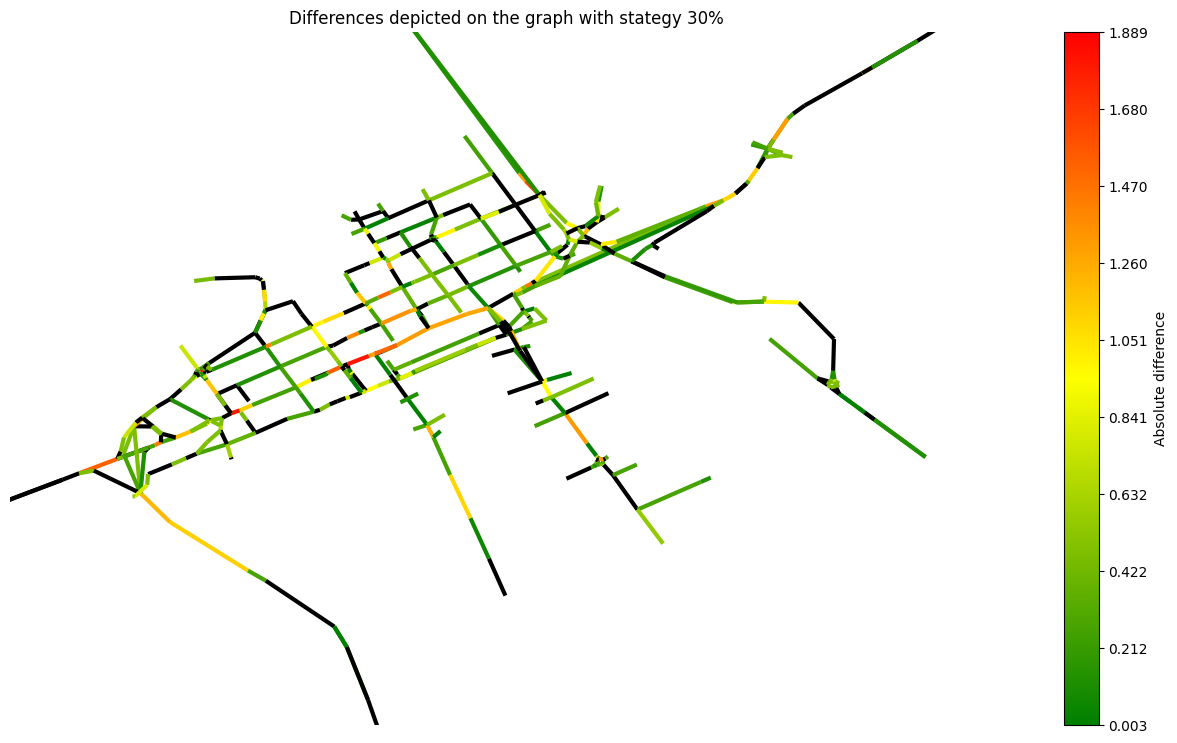

In [53]:
#plot_graph_weight(G1, output, edges_to_hide,prepared_training_data[6] )

352
[0, 1, 2, 3, 4, 5, 7, 8, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 34, 35, 37, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 63, 64, 65, 67, 69, 70, 73, 75, 76, 78, 79, 80, 81, 83, 84, 86, 88, 89, 90, 92, 93, 94, 95, 97, 99, 100, 102, 103, 108, 110, 112, 113, 115, 121, 123, 124, 126, 127, 128, 130, 134, 135, 136, 137, 138, 141, 142, 143, 145, 147, 148, 149, 150, 151, 153, 156, 157, 159, 160, 161, 162, 164, 165, 166, 168, 169, 170, 171, 173, 174, 176, 177, 180, 181, 182, 184, 185, 187, 188, 191, 193, 196, 198, 199, 202, 203, 204, 206, 207, 209, 211, 212, 213, 214, 215, 216, 217, 219, 220, 221, 224, 225, 228, 229, 230, 231, 232, 233, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 246, 247, 250, 251, 252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 264, 265, 268, 269, 270, 271, 274, 275, 276, 277, 278, 279, 280, 281, 284, 286, 288, 289, 290, 291, 292, 293, 294, 295, 298, 300, 301, 302, 305, 306, 308, 

C:\Users\nemes\AppData\Local\Temp\ipykernel_23100\3839311606.py:2: RuntimeWarning: invalid value encountered in sqrt
  geh = np.sqrt(2*np.power((float(M) - float(C)), 2) / (float(M) + float(C)))


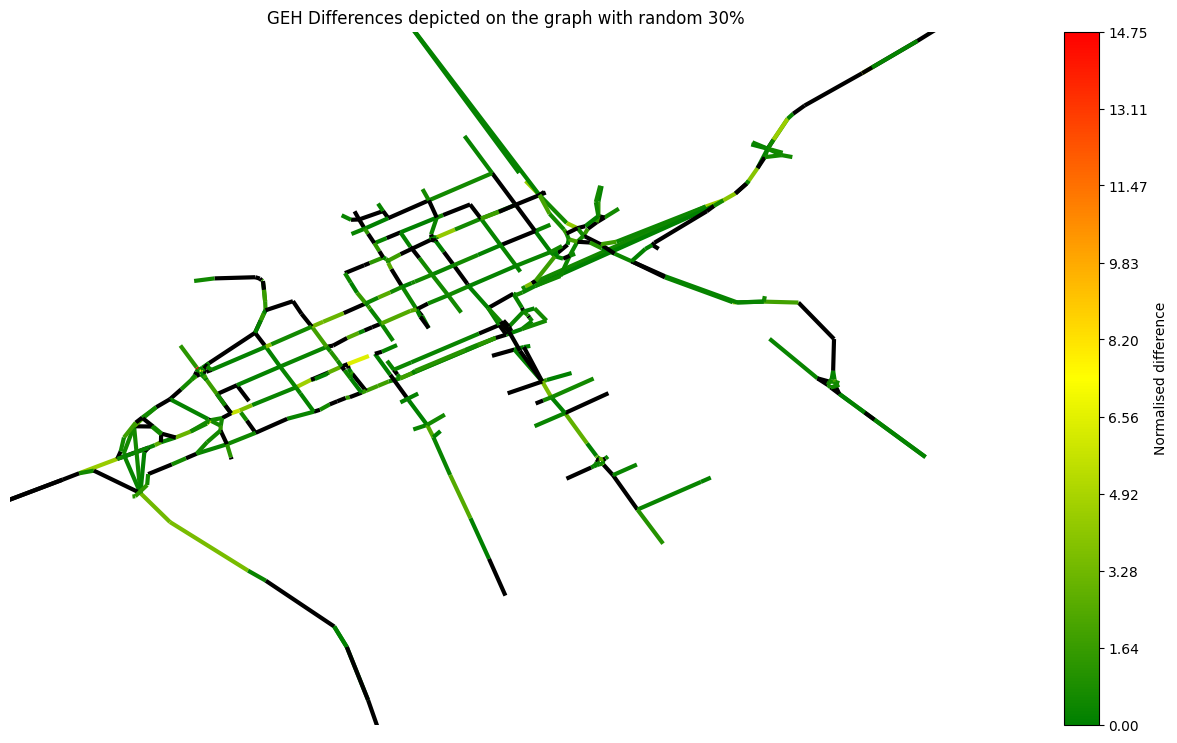

In [52]:
#plot_graph_weight_GEH(G1, output, edges_to_hide,prepared_training_data[6] )

KeyError: 1